In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [4]:
import pandas as pd
from src.config import TRANSFORMED_DATA_DIR

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

In [5]:
df["pickup_hour"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 87620 entries, 0 to 87619
Series name: pickup_hour
Non-Null Count  Dtype         
--------------  -----         
87620 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 684.7 KB


In [6]:
from datetime import datetime

from src.data_utils import split_time_series_data

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55900, 674)
(55900,)
(31720, 674)
(31720,)


In [7]:
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:
    last_4_weeks_columns = [
            f"rides_t-{7*24}",  # 1 week ago
            f"rides_t-{14*24}", # 2 weeks ago
            f"rides_t-{21*24}", # 3 weeks ago
            f"rides_t-{28*24}"  # 4 weeks ago
        ]

        # Ensure the required columns exist in the test DataFrame
    for col in last_4_weeks_columns:
        if col not in X.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate the average of the last 4 weeks
    X["average_rides_last_4_weeks"] = X[last_4_weeks_columns].mean(axis=1)

    return X

from sklearn.preprocessing import FunctionTransformer

add_feature_average_rides_last_4_weeks = FunctionTransformer(
    average_rides_last_4_weeks, validate=False
)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["hour"] = X_["pickup_hour"].dt.hour
        X_["day_of_week"] = X_["pickup_hour"].dt.dayofweek

        return X_.drop(columns=["pickup_hour", "location_id"])

add_temporal_features = TemporalFeatureEngineer()


In [9]:
import lightgbm as lgb

from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor()
)

In [10]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

# Define the parameter grid for LGBMRegressor
param_distributions = {
    "lgbmregressor__num_leaves": [2, 50, 70, 256],
    # "lgbmregressor__max_depth": [-1, 10, 20, 30],
    # "lgbmregressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
    # "lgbmregressor__n_estimators": [100, 200, 500, 1000],
    # "lgbmregressor__min_child_samples": [10, 20, 30, 50],
    # "lgbmregressor__subsample": [0.6, 0.8, 1.0],
    # "lgbmregressor__colsample_bytree": [0.6, 0.8, 1.0],
    # "lgbmregressor__reg_alpha": [0, 0.1, 0.5, 1.0],
    # "lgbmregressor__reg_lambda": [0, 0.1, 0.5, 1.0],
    # "lgbmregressor__feature_fraction": [0.6, 0.7, 0.8, 0.9, 1.0], 
    # "lgbmregressor__bagging_fraction": [0.6, 0.7, 0.8, 0.9, 1.0], 
    # "lgbmregressor__bagging_freq": [1, 5, 10],
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=5,  # Number of parameter settings sampled
    scoring="neg_mean_absolute_error",  # Use MAE as the scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score (Negative MAE):", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ........................lgbmregressor__num_leaves=2; total time=   0.1s
[CV] END ........................lgbmregressor__num_leaves=2; total time=   0.0s
[CV] END ........................lgbmregressor__num_leaves=2; total time=   0.0s
[CV] END .......................lgbmregressor__num_leaves=50; total time=   0.1s
[CV] END .......................lgbmregressor__num_leaves=50; total time=   0.0s
[CV] END .......................lgbmregressor__num_leaves=50; total time=   0.0s
[CV] END .......................lgbmregressor__num_leaves=70; total time=   0.0s
[CV] END .......................lgbmregressor__num_leaves=70; total time=   0.0s
[CV] END .......................lgbmregressor__num_leaves=70; total time=   0.0s
[CV] END ......................lgbmregressor__num_leaves=256; total time=   0.0s
[CV] END ......................lgbmregressor__num_leaves=256; total time=   0.0s
[CV] END ......................lgbmregressor__num

ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/c6/gf5pr7wx77g8bg45tg05k4q00000gn/T/ipykernel_60809/1266256322.py", line 13, in transform
    return X_.drop(columns=["pickup_hour", "location_id"])
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/frame.py", line 5581, in drop
    return super().drop(
           ^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/generic.py", line 4788, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/generic.py", line 4830, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 7070, in drop
    raise KeyError(f"{labels[mask].tolist()} not found in axis")
KeyError: "['location_id'] not found in axis"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:src.experiment_utils:MLflow tracking URI set to: https://dagshub.com/Sudeepthi-Rongali/Taxi_NYC.mlflow


(55900, 674)
(55900,)
(31720, 674)
(31720,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160168
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 675
[LightGBM] [Info] Start training from score 11.110286
Learning Rate: 0.01 | MAE: 7.922129398535997
🏃 View run chill-bee-121 at: https://dagshub.com/Sudeepthi-Rongali/Taxi_NYC.mlflow/#/experiments/3/runs/fe1a7113073b4949af27c60290b194ee
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/Taxi_NYC.mlflow/#/experiments/3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160168
[LightGBM]

INFO:src.experiment_utils:Experiment set to: LGBMRegressorWFE


Final best MAE: 3.15691251247485


INFO:src.experiment_utils:Logged mean_absolute_error: 3.15691251247485
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
INFO:src.experiment_utils:Model signature inferred.
Registered model 'Pipeline' already exists. Creating a new version of this model...
2025/03/02 19:56:21 INFO mlflow.store

🏃 View run redolent-stoat-343 at: https://dagshub.com/Sudeepthi-Rongali/Taxi_NYC.mlflow/#/experiments/4/runs/1aa7400791704fad80005f9b80c19f7d
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/Taxi_NYC.mlflow/#/experiments/4


<Figure size 1000x600 with 0 Axes>

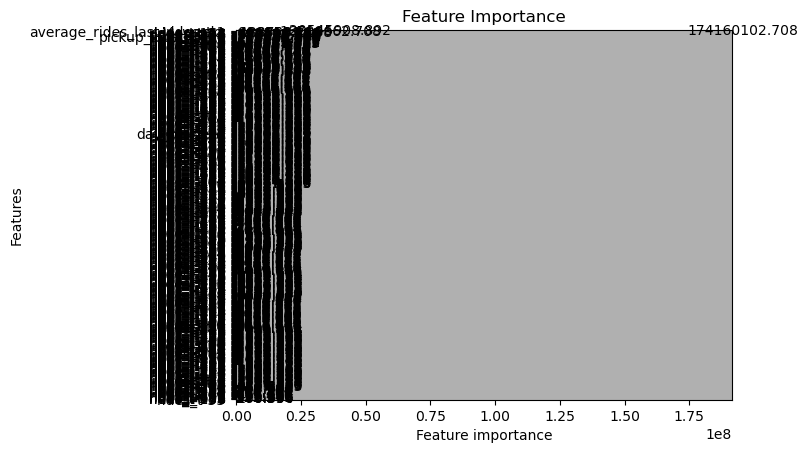

In [12]:
# Enable autoreload for code updates
%load_ext autoreload
%autoreload 2

import sys
import os
import mlflow
import mlflow.lightgbm
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from dotenv import load_dotenv

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Load dataset and utilities
from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

# Load the transformed data
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

# Train-test split
X_train, y_train, X_test, y_test = split_time_series_data(
    df, cutoff_date=datetime(2023, 9, 1, 0, 0, 0), target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Select numeric features
past_ride_columns = [c for c in X_train.columns if c.startswith("rides_")]
X_train_only_numeric = X_train[past_ride_columns].astype("float64")
X_test_only_numeric = X_test[past_ride_columns].astype("float64")

# Feature Engineering: Average rides over last 4 weeks
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:
    last_4_weeks_columns = [
        f"rides_t-{7*24}",   # 1 week ago
        f"rides_t-{14*24}",  # 2 weeks ago
        f"rides_t-{21*24}",  # 3 weeks ago
        f"rides_t-{28*24}"   # 4 weeks ago
    ]
    # Ensure the required columns exist in the DataFrame
    for col in last_4_weeks_columns:
        if col not in X.columns:
            raise ValueError(f"Missing required column: {col}")
    # Calculate the average of the last 4 weeks
    X["average_rides_last_4_weeks"] = X[last_4_weeks_columns].mean(axis=1)
    return X

# Create transformer for average rides feature
add_feature_average_rides_last_4_weeks = FunctionTransformer(
    average_rides_last_4_weeks, validate=False
)

# Updated Temporal Feature Engineering Transformer
class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        # Create new temporal features from pickup_hour
        X_["hour"] = X_["pickup_hour"].dt.hour
        X_["day_of_week"] = X_["pickup_hour"].dt.dayofweek
        # Determine which columns to drop
        cols_to_drop = []
        if "pickup_hour" in X_.columns:
            cols_to_drop.append("pickup_hour")
        if "location_id" in X_.columns:
            cols_to_drop.append("location_id")
        return X_.drop(columns=cols_to_drop, errors="ignore")

# Instantiate the temporal feature transformer
add_temporal_features = TemporalFeatureEngineer()

# Set up MLflow tracking
load_dotenv() 
mlflow = set_mlflow_tracking()
mlflow.set_experiment("NYC_Taxi_LightGBM_Feature_Engineering")

# -----------------------------
# Step 1: Tune learning_rate
# -----------------------------
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
best_mae = float("inf")
best_lr = None

for lr in learning_rates:
    with mlflow.start_run(nested=True):  # Nested run for MLflow logging
        model = lgb.LGBMRegressor(learning_rate=lr, num_leaves=31, n_estimators=100)
        
        pipeline = make_pipeline(
            add_feature_average_rides_last_4_weeks,
            add_temporal_features,
            model
        )
        
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        test_mae = mean_absolute_error(y_test, predictions)

        mlflow.log_param("learning_rate", lr)
        mlflow.log_metric("test_MAE", test_mae)

        print(f"Learning Rate: {lr} | MAE: {test_mae}")

        if test_mae < best_mae:
            best_mae = test_mae
            best_lr = lr

print(f"Best Learning Rate: {best_lr}")

# -----------------------------
# Step 2: Tune num_leaves & n_estimators with best learning_rate
# -----------------------------
num_leaves_options = [31, 50, 100]
n_estimators_options = [50, 100, 200]
best_model = None

for num_leaves in num_leaves_options:
    for n_estimators in n_estimators_options:
        with mlflow.start_run(nested=True):  # Nested run for MLflow logging
            model = lgb.LGBMRegressor(learning_rate=best_lr, num_leaves=num_leaves, n_estimators=n_estimators)
            
            pipeline = make_pipeline(
                add_feature_average_rides_last_4_weeks,
                add_temporal_features,
                model
            )

            pipeline.fit(X_train, y_train)
            predictions = pipeline.predict(X_test)
            test_mae = mean_absolute_error(y_test, predictions)

            mlflow.log_params({"num_leaves": num_leaves, "n_estimators": n_estimators})
            mlflow.log_metric("test_MAE", test_mae)

            print(f"Num Leaves: {num_leaves} | N Estimators: {n_estimators} | MAE: {test_mae}")

            if test_mae < best_mae:
                best_mae = test_mae
                best_model = pipeline

print("Final best MAE:", best_mae)

# Log best model to MLflow
log_model_to_mlflow(best_model, X_test, "LGBMRegressorWFE", "mean_absolute_error", score=best_mae)

# -----------------------------
# Feature Importance Plot
# -----------------------------
plt.figure(figsize=(10, 6))
# Extract the LightGBM regressor from the pipeline using its name (assumed to be "lgbmregressor")
lgb.plot_importance(best_model.named_steps["lgbmregressor"], importance_type="gain")
plt.title("Feature Importance")
plt.show()


| **Hyperparameter**       | **Description**                                                                                                                                                                                                 | **Impact**                                                                                                                                                                                                                     |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `num_leaves`             | Maximum number of leaves in one tree. Larger values increase model complexity and accuracy but may lead to overfitting.                                                                                         | High: Directly controls the complexity of the model. Larger values can improve accuracy but increase the risk of overfitting.                                                                                                  |
| `max_depth`              | Maximum depth of a tree. Limits the depth of the tree to prevent overfitting. Use `-1` for no limit.                                                                                                           | High: Limits the model's ability to capture complex patterns. Shallower trees reduce overfitting but may underfit.                                                                                                             |
| `learning_rate`          | Step size for updating weights. Smaller values make training slower but improve generalization.                                                                                                                | High: Affects convergence speed and generalization. Lower values often require more iterations (`n_estimators`).                                                                                                               |
| `n_estimators`           | Number of boosting iterations (trees). Higher values improve accuracy but increase training time.                                                                                                              | High: Controls the number of trees in the ensemble. Too many trees can lead to overfitting if `learning_rate` is not adjusted.                                                                                                |
| `feature_fraction`       | Fraction of features (columns) to randomly select for each tree. Helps prevent overfitting.                                                                                                                    | Medium-High: Reduces overfitting and speeds up training. Lower values may lead to underfitting.                                                                                                                               |
| `bagging_fraction`       | Fraction of data (rows) to randomly select for each iteration. Works with `bagging_freq`.                                                                                                                       | Medium-High: Reduces overfitting and improves generalization. Lower values may lead to underfitting.                                                                                                                           |
| `bagging_freq`           | Frequency of bagging. For example, `5` means bagging is performed every 5 iterations.                                                                                                                          | Medium: Works with `bagging_fraction` to control how often bagging is applied.                                                                                                                                                |
| `min_child_samples`      | Minimum number of data points required in a leaf. Larger values prevent overfitting by limiting leaf size.                                                                                                     | Medium: Controls overfitting by limiting the size of leaf nodes. Higher values may lead to underfitting.                                                                                                                       |
| `colsample_bytree`       | Alias for `feature_fraction`. Fraction of features to randomly select for each tree.                                                                                                                            | Medium: Similar to `feature_fraction`, reduces overfitting and speeds up training.                                                                                                                                            |
| `subsample`              | Alias for `bagging_fraction`. Fraction of data to randomly select for each iteration.                                                                                                                           | Medium: Similar to `bagging_fraction`, reduces overfitting and improves generalization.                                                                                                                                       |
| `reg_alpha`              | L1 regularization term on weights. Adds a penalty for large coefficients to reduce overfitting.                                                                                                                | Medium: Helps reduce overfitting, especially in high-dimensional data.                                                                                                                                                        |
| `reg_lambda`             | L2 regularization term on weights. Adds a penalty for large coefficients to reduce overfitting.                                                                                                                | Medium: Similar to `reg_alpha`, but penalizes squared coefficients.                                                                                                                                                           |
| `max_bin`                | Maximum number of bins for discretizing continuous features. Higher values improve accuracy but increase training time.                                                                                         | Medium: Affects how continuous features are bucketed. Higher values improve precision but increase computational cost.                                                                                                         |
| `min_split_gain`         | Minimum gain required to split a node. Higher values prevent splitting nodes with low information gain.                                                                                                         | Medium-Low: Helps control overfitting by limiting unnecessary splits.                                                                                                                                                         |
| `boosting_type`          | Type of boosting algorithm. Options: `gbdt` (default), `dart`, `goss`.                                                                                                                                          | Medium-Low: Affects the boosting strategy. `dart` and `goss` are alternatives to `gbdt` for specific use cases.                                                                                                               |
| `objective`              | Objective function to optimize. Common options: `regression`, `regression_l1`, `huber`, `fair`.                                                                                                                | Medium-Low: Determines the loss function. Impacts how the model optimizes predictions.                                                                                                                                         |
| `verbosity`              | Controls the level of logging. Higher values provide more detailed logs.                                                                                                                                       | Low: Does not affect model performance but helps with debugging.                                                                                                                                                              |
| `random_state`           | Seed for reproducibility. Ensures consistent results across runs.                                                                                                                                               | Low: Does not affect model performance but ensures reproducibility.                                                                                                                                                           |
| `early_stopping_round`   | Stops training if validation score does not improve for a specified number of rounds.                                                                                                                           | Low: Helps save time during training but does not directly affect model performance.                                                                                                                                           |